In [50]:
# import libraries
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import SGD, Adam

%matplotlib inline

In [51]:
# import dataset
from sklearn.datasets import load_digits
mnist = load_digits()
data = mnist.images.astype(np.float32)
labels = mnist.target.astype(np.int32)
print(data)
print(labels)
mnist.keys()

[[[ 0.  0.  5. ...  1.  0.  0.]
  [ 0.  0. 13. ... 15.  5.  0.]
  [ 0.  3. 15. ... 11.  8.  0.]
  ...
  [ 0.  4. 11. ... 12.  7.  0.]
  [ 0.  2. 14. ... 12.  0.  0.]
  [ 0.  0.  6. ...  0.  0.  0.]]

 [[ 0.  0.  0. ...  5.  0.  0.]
  [ 0.  0.  0. ...  9.  0.  0.]
  [ 0.  0.  3. ...  6.  0.  0.]
  ...
  [ 0.  0.  1. ...  6.  0.  0.]
  [ 0.  0.  1. ...  6.  0.  0.]
  [ 0.  0.  0. ... 10.  0.  0.]]

 [[ 0.  0.  0. ... 12.  0.  0.]
  [ 0.  0.  3. ... 14.  0.  0.]
  [ 0.  0.  8. ... 16.  0.  0.]
  ...
  [ 0.  9. 16. ...  0.  0.  0.]
  [ 0.  3. 13. ... 11.  5.  0.]
  [ 0.  0.  0. ... 16.  9.  0.]]

 ...

 [[ 0.  0.  1. ...  1.  0.  0.]
  [ 0.  0. 13. ...  2.  1.  0.]
  [ 0.  0. 16. ... 16.  5.  0.]
  ...
  [ 0.  0. 16. ... 15.  0.  0.]
  [ 0.  0. 15. ... 16.  0.  0.]
  [ 0.  0.  2. ...  6.  0.  0.]]

 [[ 0.  0.  2. ...  0.  0.  0.]
  [ 0.  0. 14. ... 15.  1.  0.]
  [ 0.  4. 16. ... 16.  7.  0.]
  ...
  [ 0.  0.  0. ... 16.  2.  0.]
  [ 0.  0.  4. ... 16.  2.  0.]
  [ 0.  0.  5. ... 12.  0.  

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [52]:
print(mnist.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

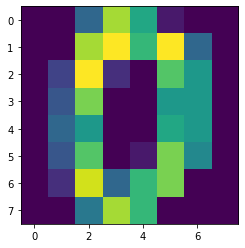

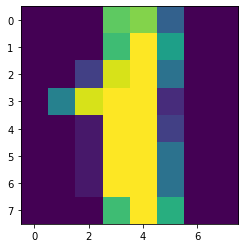

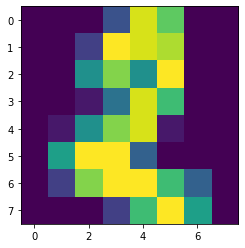

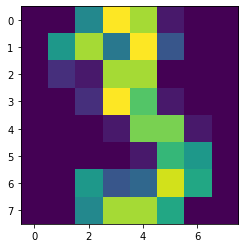

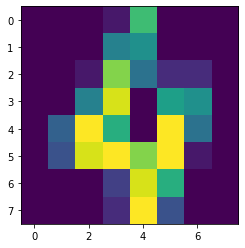

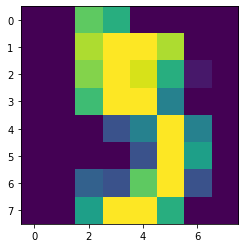

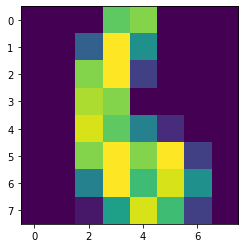

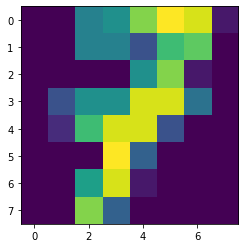

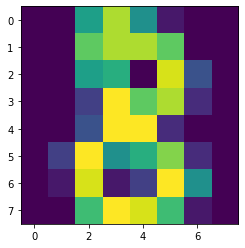

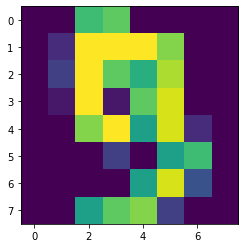

In [53]:
# plot the first 10 numbers using plt

for i in range(10): 
    plt.imshow(mnist.images[i])
    plt.show()

In [54]:
# define neural network
class CNNNumberClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # input channel is 1 since image is grayscale
        # switching from conv2d, relu, and batch norm
        L = [
            torch.nn.Conv2d(1, 32, kernel_size=2), 
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32, 64, kernel_size=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(64, 128, kernel_size=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(128, 256, kernel_size=2), 
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 128, kernel_size=2), 
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(128, 64, kernel_size=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
        ]
        
        # initialize network
        self.network = torch.nn.Sequential(*L)
        
        # classify numbers between 0-9
        self.classifier = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        z = self.network(x)
        z = z.mean([2,3])
        return self.classifier(z)

In [55]:
# define dataset class
from torch.utils.data import Dataset
class DigitsDataset(Dataset):
    def __init__(self, features, labels):
        self.data = []
        for x,y in zip(features, labels): 
            self.data.append((torch.tensor(x, dtype=torch.float32).unsqueeze(0),y))
        
    def __len__(self):
        return len(self.data)

                             
    def __getitem__(self, idx):
        return self.data[idx]
                         

In [56]:
# process data into tensors
data = []
for image_data in mnist.images:
    data.append(torch.tensor(image_data, dtype=torch.float64))

In [57]:
def accuracy(outputs, labels):
    outputs_idx = outputs.max(1)[1].type_as(labels)
    return outputs_idx.eq(labels).float().mean()

In [58]:
# train the model
model = CNNNumberClassifier()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# split dataset into train (80%)
train_features, temp_features, train_labels, temp_labels = train_test_split(data, labels,
                                                                   random_state=42, test_size=.2)

# use remaining 20% of dataset and split it into validation (10%) and test datasets (10%)
valid_features, test_features, valid_labels, test_labels = train_test_split(temp_features, temp_labels,
                                                                    random_state=42, test_size=.5)

# create dataset classes for train and valid
train_data = DigitsDataset(train_features, train_labels)
valid_data = DigitsDataset(valid_features, valid_labels)

# place training data inside of dataloader
data_loader_train = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
data_loader_valid = DataLoader(valid_data, batch_size=32, shuffle=True, drop_last=True)

# optimizer
optimizer = SGD(model.parameters(), lr=.001, momentum=.9, weight_decay=.0001)


# train the network epoch amount of times
epochs = 100

global_steps = 0

train_loss = []
valid_loss = []

for i in range(epochs):
    # iterate over the training dataset
    train_acc = []
    model.train()
    for x, y in data_loader_train:
        global_steps += 1
        optimizer.zero_grad()
        output = model(x)
        loss = F.cross_entropy(output, y.long())
        loss.backward()
        
        # now compute accuracy
        acc = accuracy(output, y)

        # log accuracy 
        train_acc.append(acc.item())
        
        # train loss
        train_loss.append()
        
        optimizer.step()
    # log average accuracy
    avg_train_acc = torch.mean(torch.tensor(train_acc)).item()
    #print('accuracy of batch: ', avg_train_acc)
    
    
    # iterate over validation dataset
    model.eval()
    valid_acc = []
    for x, y in data_loader_valid:
        # put inputs and labels into gpu
        #inputs = inputs.to(device)
        #labels = labels.to(device)

        # predict data 
        outputs = model(x)

        # compute accuracy 
        acc = accuracy(outputs, y)
            
        # append accuracy to list
        valid_acc.append(acc.item())
    #print('accuracy of validation: ', str(torch.mean(torch.tensor(valid_acc)).item()))


/var/folders/1t/51hvg6f90_s_pk5sxz5549b00000gn/T/ipykernel_11647/3623797631.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data.append((torch.tensor(x, dtype=torch.float32).unsqueeze(0),y))


In [59]:
# plot training and validation losses 


In [60]:
# run model on testing data and report accuracy
test_data = DigitsDataset(test_features, test_labels)
data_loader_test = DataLoader(test_data, batch_size=1)

model.eval()
test_accuracies = []
for x, y in data_loader_test:
    # predict data 
    outputs = model(x)

    # compute accuracy 
    acc = accuracy(outputs, y)
            
    # append accuracy to list
    test_accuracies.append(acc.item())
    
print("accuracy on test: ", str(torch.mean(torch.tensor(test_accuracies)).item()))

accuracy on test:  0.9944444298744202


/var/folders/1t/51hvg6f90_s_pk5sxz5549b00000gn/T/ipykernel_11647/3623797631.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data.append((torch.tensor(x, dtype=torch.float32).unsqueeze(0),y))
